**Name: Zahra Dehghanian**

**Student ID: 401300417**

In this practical assignment, we will develope a U-Net for semantis segmentation of lung CT-scans.

For this task, you will use a dataset consisting of CT-scans from lungs of COVID-19 patients. The regions affected by COVID-19 are marked with labels of ground glass opacity. You will be training and testing the U-Net model on this dataset.

## Imports

In [56]:
# Import any needed packages here
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image

## Prepare Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/images.zip", "r")
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/masks.zip", "r")
zip_ref.extractall()
zip_ref.close()
images = np.load('images_medseg.npy').astype(np.float32)
masks = np.load('masks_medseg.npy').astype(np.float32)

In [59]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

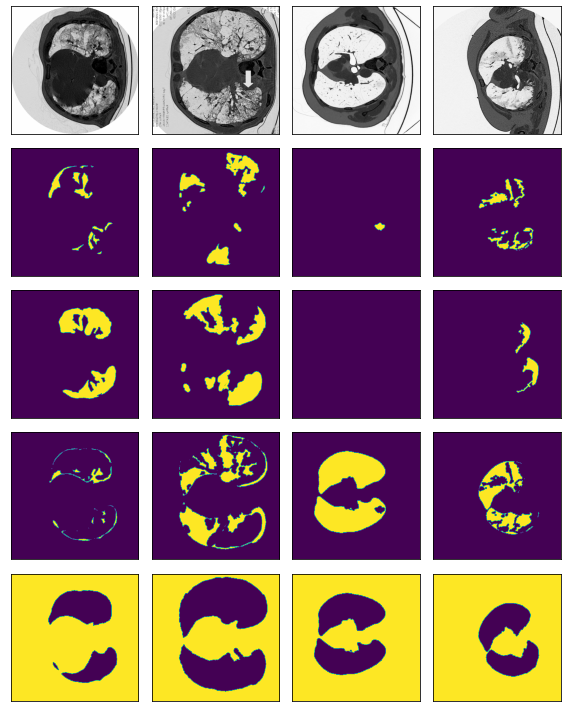

In [60]:
import matplotlib.pyplot as plt

# plt.style.use("dark_background")
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=4):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()


visualize(images, masks)

## Create Your Dataset Class (10%)

In [61]:
class CovidCTDataset(Dataset):

    def __init__(self, images,masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.images[idx]
        label = self.masks[idx]
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = np.array(Image.fromarray(np.uint8(img*255)).resize((224,224)).convert('RGB'))
        label =np.expand_dims(np.array(Image.fromarray(np.uint8(label)).resize((224,224))), axis=0)
        return torch.from_numpy(img.transpose((2, 0, 1))).float() , torch.from_numpy(label).float()


covidDataset = CovidCTDataset(images[:,:,:,0],masks[:,:,:,0])
print(covidDataset.images.shape)
print(covidDataset.masks.shape)

(100, 512, 512)
(100, 512, 512)


## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [62]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 5
train_split = 0.8
valid_split = 0.1

# Create indices for the split
dataset_size = len(covidDataset)
train_size = int(train_split * dataset_size)
valid_size = int(valid_split * dataset_size)
test_size =  dataset_size - train_size - valid_size

# Split the train and validation data and create dataloaders
train_dst,valid_dst,test_dst = random_split(covidDataset, [train_size,valid_size, test_size])
train_loader = DataLoader(train_dst,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_dst,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dst,batch_size=batch_size,shuffle=True)


In [63]:
# testing one pass
xb, yb = next(iter(train_loader))
print(xb.shape, yb.shape)
print(xb.dtype, yb.dtype)


torch.Size([5, 3, 224, 224]) torch.Size([5, 1, 224, 224])
torch.float32 torch.float32


## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

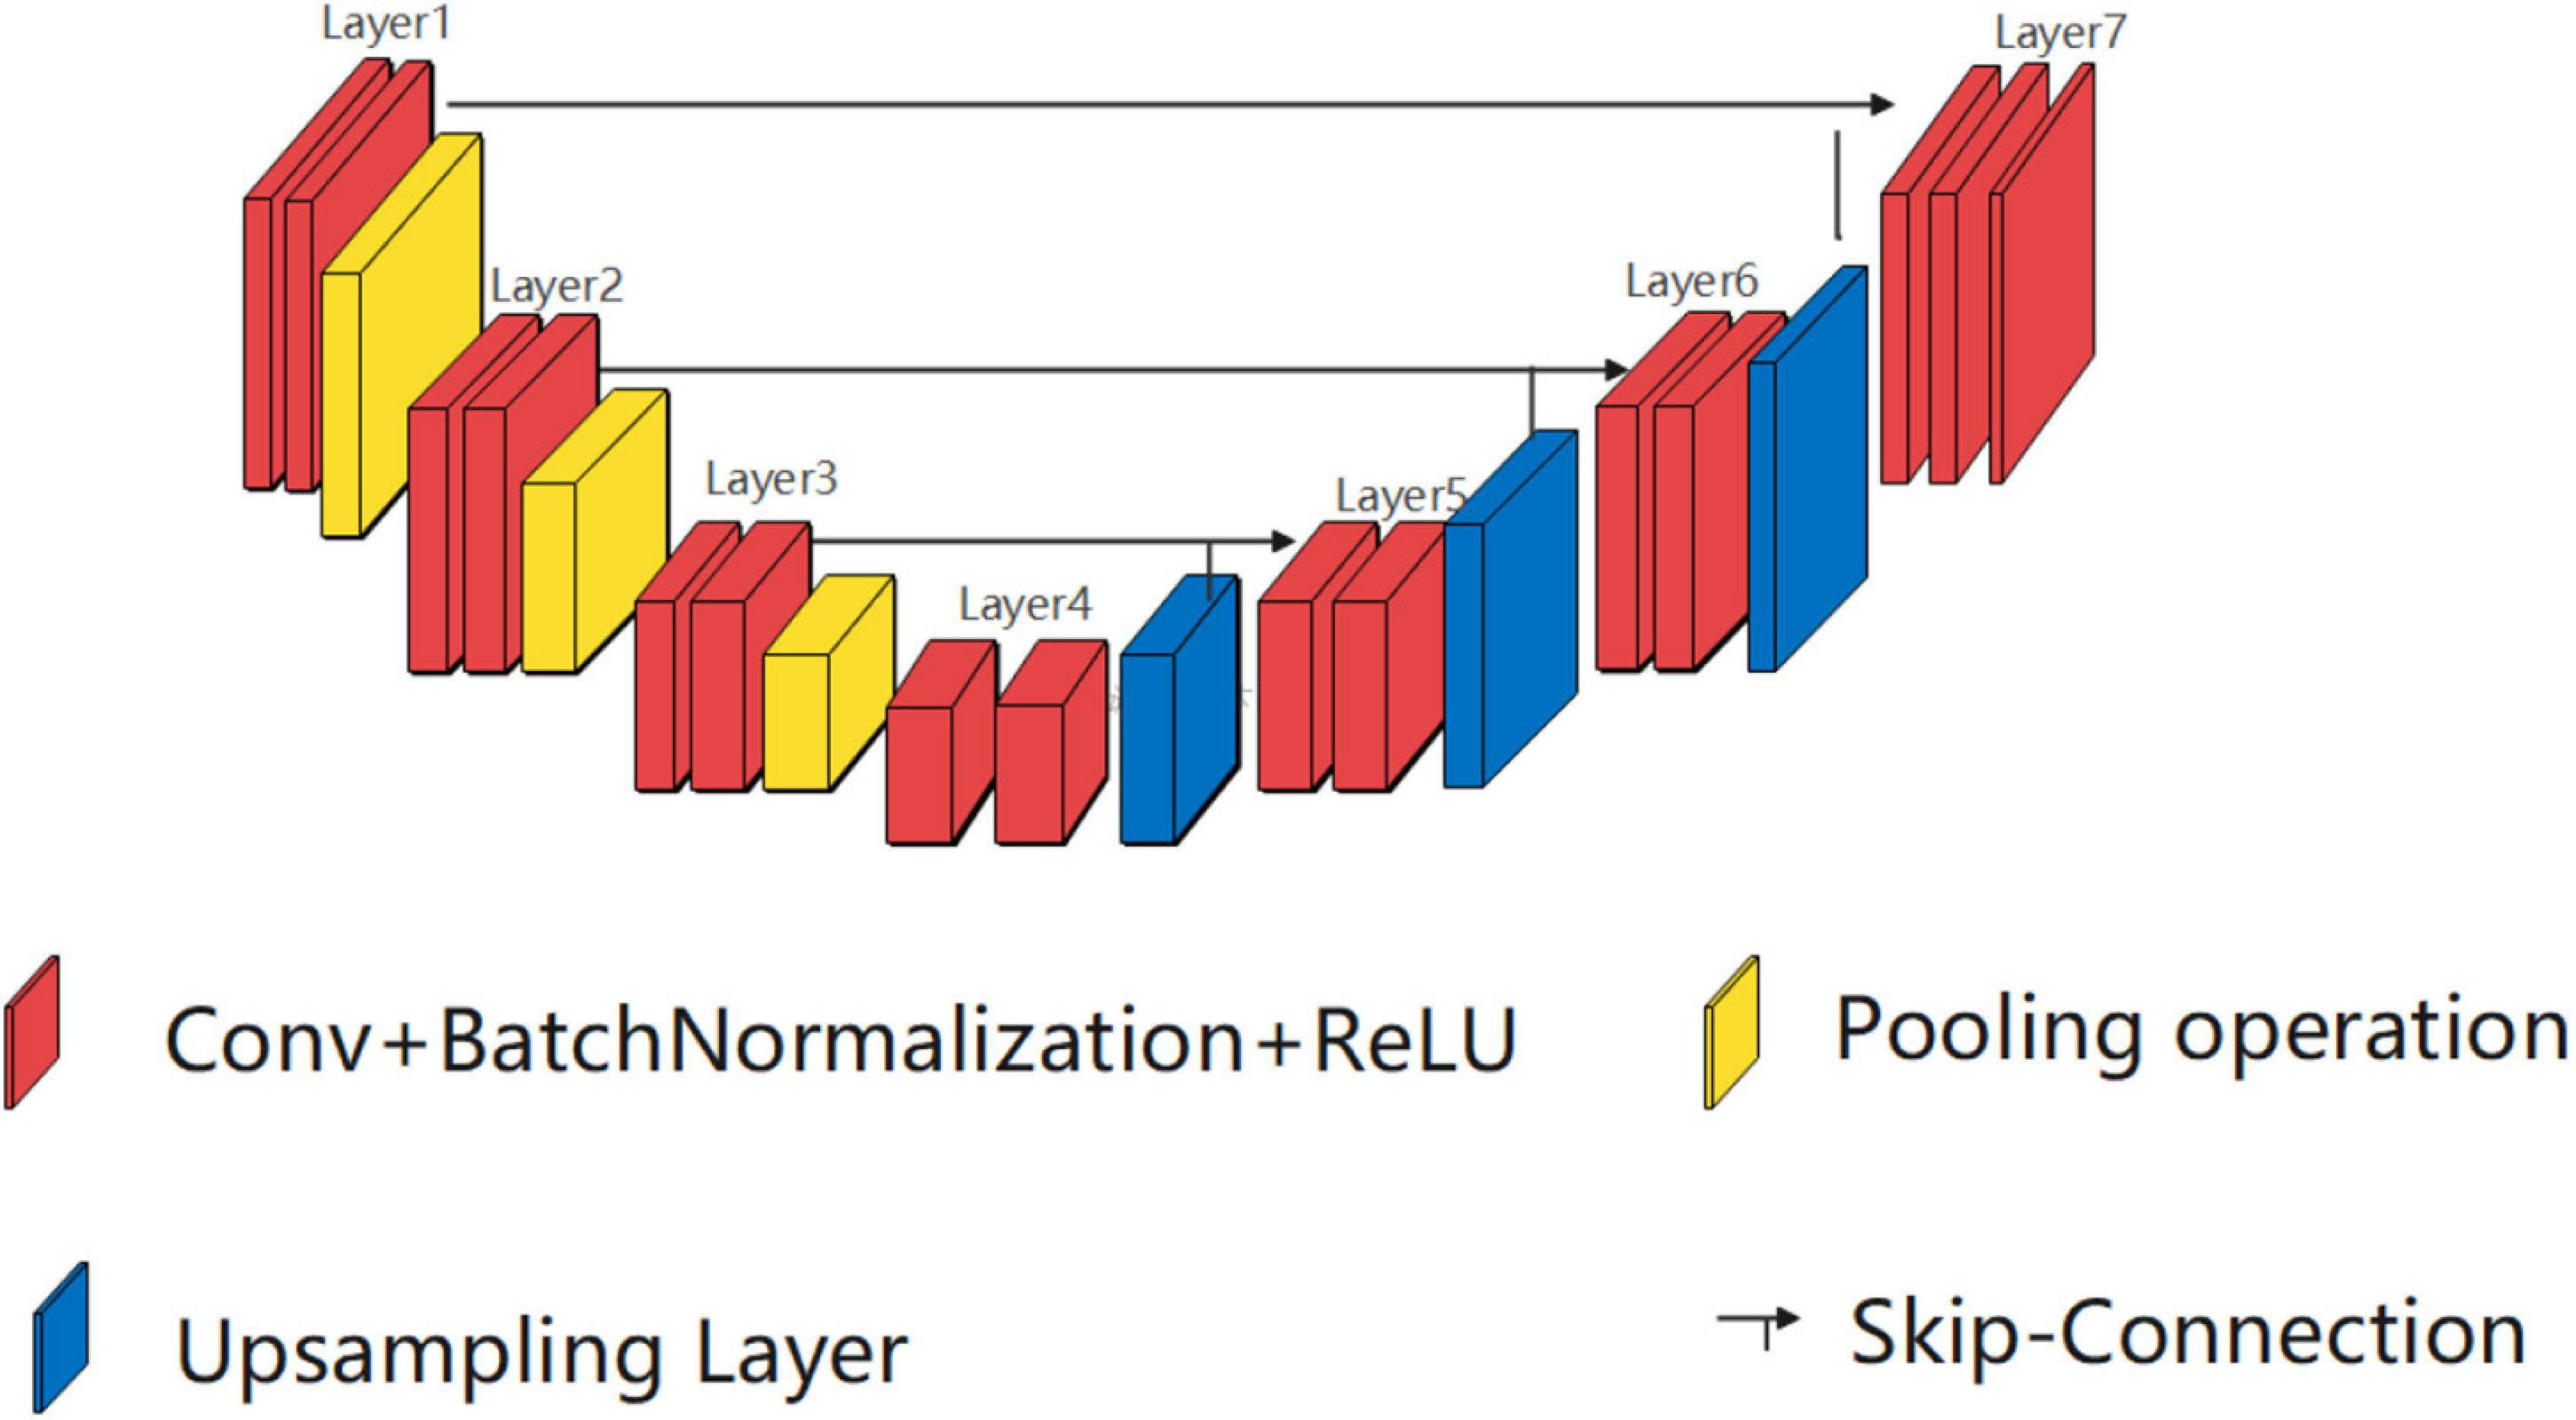

In [64]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(128*2, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, 16, 3, 1)

        self.outputs = nn.Conv2d(16,out_channels, kernel_size=3, padding=1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        outputs = self.outputs(upconv1)

        return torch.sigmoid(outputs)

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

## Define your model, optimizer, and loss function (5%)

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [65]:
unet = UNET(3,1)
loss_fn = nn.BCELoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.0001)

In [66]:
pred = unet(xb)
pred.shape

torch.Size([5, 1, 224, 224])

## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [67]:
def make_binary(t):
  image = torch.where(t < 0.3, 0, 1)
  return image

In [68]:
def acc_metric(predb, yb):
    predb = make_binary(predb)
    return (predb == yb).float().mean()
    
def iou_metric(yb_p, yb):
    yb_p = make_binary(yb_p)
    yb = (yb==1)
    yb_p = (yb_p==1)
    intersection = np.count_nonzero(np.logical_and(yb , yb_p))
    yb =  np.count_nonzero(yb)
    yb_p =  np.count_nonzero(yb_p) 
    Iou = 0.0
    Iou = intersection  /( yb+ yb_p - intersection)
    return Iou

## Train and test function (25%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

In [69]:
import time
from IPython.display import clear_output
torch.set_printoptions(precision=2)

filepath = "/content/gdrive/MyDrive/Colab Notebooks/segmentation/"

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, iou_fn, epochs=1):
    start = time.time()
    train_loss, valid_loss = [], []
    train_iou, valid_iou = [], []
    best_iou = 0.3

    for epoch in range(epochs):
        if epoch % 5 == 0 :
          print('-' * 10)
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_acc = 0.0
            running_iou = 0.0
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_loader
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_loader
            step = 0
            for x, y in dataloader:
                step += 1
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn((outputs), y)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y)

                iou = iou_fn(outputs,y)
                acc = acc_fn(outputs, y)
                running_iou  += iou*dataloader.batch_size
                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            epoch_iou = running_iou / len(dataloader.dataset)

            if phase == 'valid':
              if epoch_iou > best_iou  :
                best_iou = epoch_iou
                torch.save(unet.state_dict(), filepath+str(epoch_iou)+".pth")
                print("best model updated to new one!")

            if epoch % 5 == 0 :
              print('Epoch {}/{} {} Loss: {:.4f} Acc: {} iou: {}'.format(epoch, epochs - 1,phase, epoch_loss, epoch_acc,epoch_iou))
            
            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_iou.append(epoch_iou) if phase=='train' else valid_iou.append(epoch_iou)
            
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss,train_iou,valid_iou, model

train_loss, valid_loss,train_iou,valid_iou,unet = train(unet, train_loader, valid_loader, loss_fn, opt, acc_metric, iou_metric, epochs=100)

----------
Epoch 0/99 train Loss: 0.6521 Acc: 0.04528908059000969 iou: 0.04528669724798405
Epoch 0/99 valid Loss: 0.6408 Acc: 0.04363640025258064 iou: 0.04363639987244898
----------
Epoch 5/99 train Loss: 0.4947 Acc: 0.06693065166473389 iou: 0.046294520021671434
Epoch 5/99 valid Loss: 0.4780 Acc: 0.09235092252492905 iou: 0.04611695215503397
----------
Epoch 10/99 train Loss: 0.2609 Acc: 0.8995541334152222 iou: 0.285860054968353
best model updated to new one!
Epoch 10/99 valid Loss: 0.2604 Acc: 0.9155651926994324 iou: 0.31911415293860806
best model updated to new one!
best model updated to new one!
best model updated to new one!
best model updated to new one!
----------
Epoch 15/99 train Loss: 0.1463 Acc: 0.9538769721984863 iou: 0.4287991360399051
Epoch 15/99 valid Loss: 0.1363 Acc: 0.9557019472122192 iou: 0.4343716195782397
----------
Epoch 20/99 train Loss: 0.1064 Acc: 0.9602957963943481 iou: 0.46761549770087274
Epoch 20/99 valid Loss: 0.1099 Acc: 0.9575393795967102 iou: 0.42107768962

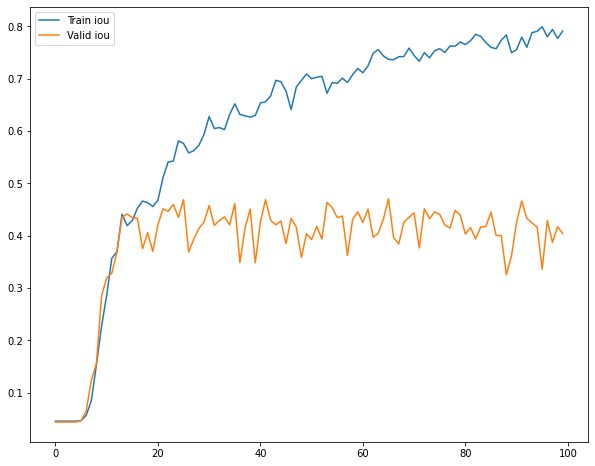

In [71]:
plt.figure(figsize=(10,8))
plt.plot(train_iou, label='Train iou')
plt.plot(valid_iou, label='Valid iou')
plt.legend()

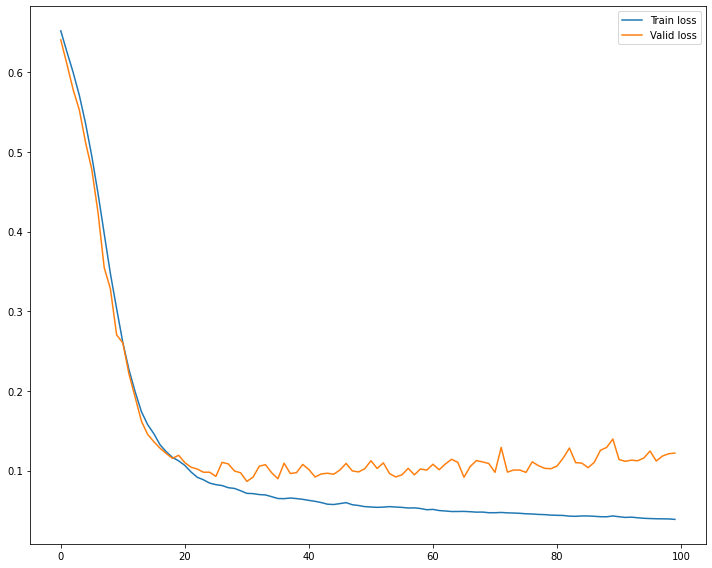

In [72]:
l = []
for i in train_loss :
  l.append(i.detach().numpy())
plt.figure(figsize=(10,8))
plt.plot(l, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.tight_layout()
plt.show()

load best model

In [70]:
filepath = "/content/gdrive/MyDrive/Colab Notebooks/segmentation/0.4705522814258738.pth"
unet.load_state_dict(torch.load(filepath))
unet.eval()

## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

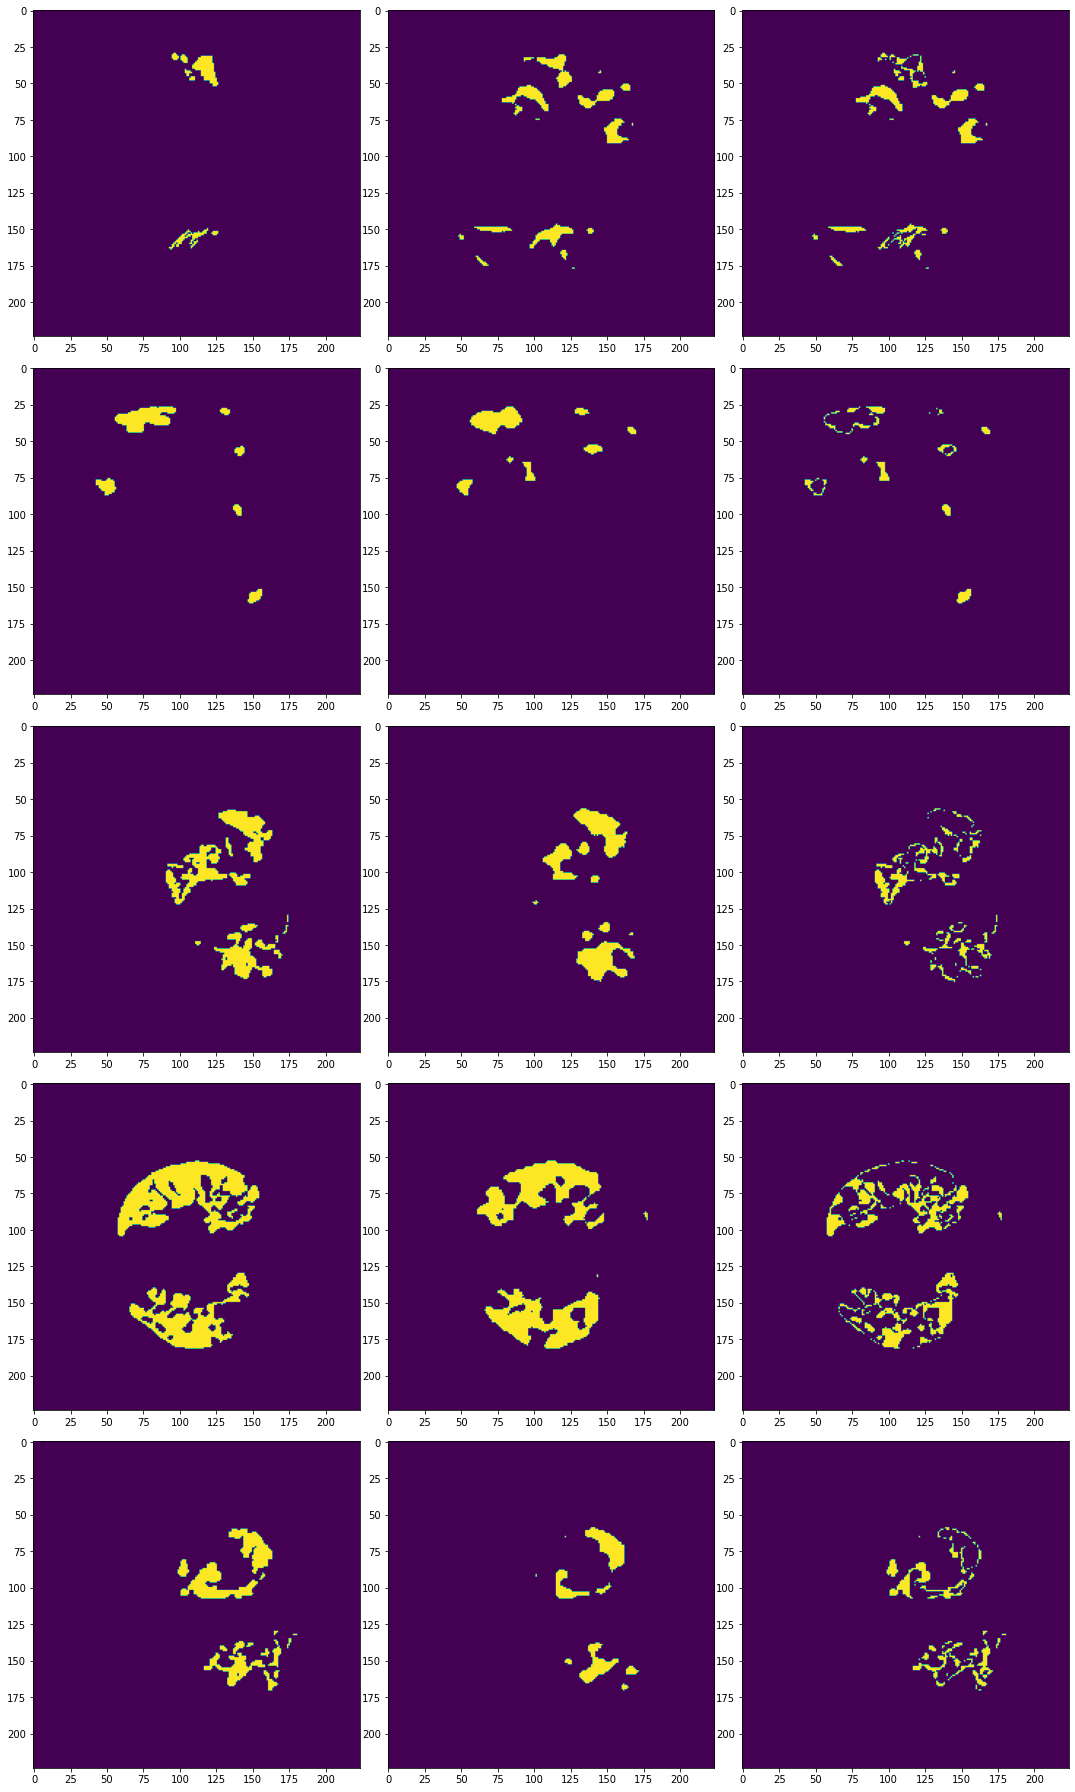

accuracy test time = 0.9773995280265808
Iou test time = 0.4832771347853823


In [77]:
def test(model, test_loader):
  xb, yb = next(iter(test_loader))
  with torch.no_grad():
    predb = model(xb)
  bs = batch_size
  fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
  predb = make_binary(predb)
  for i in range(bs):
      ax[i,0].imshow(yb[i][0])
      ax[i,1].imshow((predb)[i][0])
      ax[i,2].imshow(yb[i][0]!=predb[i][0])
  plt.tight_layout()
  plt.show()

  acc = acc_metric(predb, yb)
  print("accuracy test time = "+str(float(acc)))
  iou = iou_metric(predb, yb)
  print("Iou test time = "+str(iou))
  
test (unet, test_loader)

## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 

In [74]:
class IoULoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    @staticmethod
    def _IoU(y_pred, y_true):
        y_pred_flat = torch.flatten(y_pred)
        y_true_flat = torch.flatten(y_true)
        intersection = torch.sum(y_pred_flat * y_true_flat)
        union = torch.sum(y_pred_flat) + torch.sum(y_true_flat) - intersection
        return intersection / union

    def forward(self, y_pred, y_true):
        # # Binarize prediction
        # y_pred = torch.where(y_pred < 0.3, 0, 1)
        return 1 - self._IoU(y_pred, y_true)

In [75]:
import time
from IPython.display import clear_output
torch.set_printoptions(precision=2)

filepath = "/content/gdrive/MyDrive/Colab Notebooks/segmentation/"

def train_improved(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, iou_fn, epochs=1):
    start = time.time()
    train_loss, valid_loss = [], []
    train_iou, valid_iou = [], []
    best_iou = 0.3
    for epoch in range(epochs):
        if epoch % 5 == 0 :
          print('-' * 10)
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_acc = 0.0
            running_iou = 0.0
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_loader
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_loader
            step = 0
            for x, y in dataloader:
                step += 1
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss1 = loss_fn[0]((outputs), y)
                    loss2 = loss_fn[1]((outputs), y)
                    loss = 3*loss1 + loss2
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)
                    loss1 = loss_fn[0]((outputs), y)
                    loss2 = loss_fn[1]((outputs), y)
                    loss = 3*loss1 + loss2

                iou = iou_fn(outputs,y)
                acc = acc_fn(outputs, y)
                running_iou  += iou*dataloader.batch_size
                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            epoch_iou = running_iou / len(dataloader.dataset)

            if phase == 'valid':
              if epoch_iou > best_iou  :
                best_iou = epoch_iou
                torch.save(unet.state_dict(), filepath+str(epoch_iou)+".pth")
                print("best model updated to new one!")

            if epoch % 5 == 0 :
              print('Epoch {}/{} {} Loss: {:.4f} Acc: {} iou: {}'.format(epoch, epochs - 1,phase, epoch_loss, epoch_acc,epoch_iou))
            
            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_iou.append(epoch_iou) if phase=='train' else valid_iou.append(epoch_iou)
            
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss,train_iou,valid_iou, model


In [76]:
loss_fn_improved =[IoULoss() ,nn.BCELoss()]
opt = torch.optim.Adam(unet.parameters(), lr=0.0001)

train_loss_i, valid_loss_i,train_iou_i,valid_iou_i,unet_improved = train_improved(unet, train_loader, valid_loader, loss_fn_improved, opt, acc_metric, iou_metric, epochs=30)

----------
Epoch 0/29 train Loss: 1.7145 Acc: 0.9885562062263489 iou: 0.7711912806271413
best model updated to new one!
Epoch 0/29 valid Loss: 2.2450 Acc: 0.9648576974868774 iou: 0.4652829212298286
----------
Epoch 5/29 train Loss: 1.5884 Acc: 0.9893894195556641 iou: 0.7856008909532737
Epoch 5/29 valid Loss: 2.2129 Acc: 0.9600147008895874 iou: 0.4398635163817519
----------
Epoch 10/29 train Loss: 1.5049 Acc: 0.9905333518981934 iou: 0.7866924568732914
Epoch 10/29 valid Loss: 2.1779 Acc: 0.9643375277519226 iou: 0.4562957694826414
----------
Epoch 15/29 train Loss: 1.3931 Acc: 0.990225613117218 iou: 0.7938167958559593
Epoch 15/29 valid Loss: 2.3997 Acc: 0.9659658670425415 iou: 0.35802940841196007
----------
Epoch 20/29 train Loss: 1.2802 Acc: 0.9903417825698853 iou: 0.806351928080008
Epoch 20/29 valid Loss: 2.3209 Acc: 0.9648178219795227 iou: 0.4098027849343639
----------
Epoch 25/29 train Loss: 1.1782 Acc: 0.9913299679756165 iou: 0.8144882063791474
Epoch 25/29 valid Loss: 2.1634 Acc: 0.9